In [ ]:
!pip uninstall keras
!pip uninstall tensorflow
!pip install keras==2.12.0
!pip install tensorflow==2.12.0
!pip install Keras-Preprocessing


Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/keras-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/keras/*
Proceed (Y/n)? y
  Successfully uninstalled keras-2.15.0
Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.9 MB/s eta 0:00:00
     ━━━

In [ ]:
import numpy as np
import tensorflow as tf
!pip install utils
from utils import *
from glob import glob
import  cv2
IMG_SIZE = (256,256)

def gen_example(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMG_SIZE)
    label_path = img_path.replace('/images/','/labels/').replace('.jpg','.txt')
    labels = np.loadtxt(label_path,delimiter=' ')
    label_wh = labels[:,[3,4]]
    label_xy = labels[:,[1,2]]
    boxes = np.hstack([label_xy-0.5*label_wh,label_xy+0.5*label_wh])
    boxes = boxes*(img.shape[:2]+img.shape[:2])
    K_loc = 0.5*(boxes[:,[2,3]]+boxes[:,[0,1]])
    K_bw = 0.5*(boxes[:,[2,3]]-boxes[:,[0,1]])
    ys, xs = np.ogrid[0:img.shape[0]:IMG_SIZE[0]*1j, 0:img.shape[1]:IMG_SIZE[1]*1j]
    dens = 0
    for (loc_x,loc_y),(bw_x,bw_y) in zip(K_loc,K_bw):
        bw_x, bw_y = 10,10 # use constant rather than actual size for simplicity
        dens_update = np.clip(1-np.abs(loc_x-xs)/bw_x,0,1)*np.clip(1-np.abs(loc_y-ys)/bw_y,0,1)
        # dens_update = dens_update * 1/dens_update.sum() # normalize
        dens = dens + dens_update
    return img,dens


def gen_data(subpath='train'):
    def gen():
        for img_path in glob(f'/content/drive/MyDrive/hi/{subpath}/images/*.jpg'):
            img,dens = gen_example(img_path)
            yield img,dens
    return gen


train_ds = tf.data.Dataset.from_generator(
     gen_data('train'),
     output_signature=(
         tf.TensorSpec(shape=IMG_SIZE+(3,), dtype=tf.float32),
         tf.TensorSpec(shape=IMG_SIZE, dtype=tf.float32)
    )
)
train_ds = train_ds.shuffle(100).batch(32).prefetch(1).cache()

val_ds = tf.data.Dataset.from_generator(
     gen_data('valid'),
     output_signature=(
         tf.TensorSpec(shape=IMG_SIZE+(3,), dtype=tf.float32),
         tf.TensorSpec(shape=IMG_SIZE, dtype=tf.float32)
    )
)
val_ds = val_ds.shuffle(1000).batch(32).prefetch(1).cache()

test_ds = tf.data.Dataset.from_generator(
     gen_data('test'),
     output_signature=(
         tf.TensorSpec(shape=IMG_SIZE+(3,), dtype=tf.float32),
         tf.TensorSpec(shape=IMG_SIZE, dtype=tf.float32)
    )
)
test_ds = test_ds.batch(32).prefetch(1).cache()

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13905 sha256=488cffede1dfbcaa8fd71c6dade11f5590d9fa55c6323aa1dc0c6000319653f3
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [ ]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256), dtype=tf.float32, name=None))>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


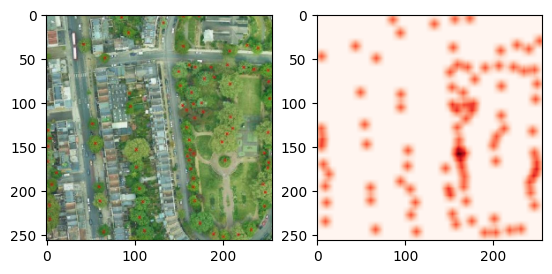

In [ ]:
import matplotlib.pyplot as plt

img,dens = next(train_ds.unbatch().as_numpy_iterator())
fig,axs = plt.subplots(1,2)
axs[0].imshow(img)
axs[1].imshow(dens,cmap="Reds")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def get_simplified_model(input_shape):
    model = tf.keras.Sequential([
        # Convolutional Block 1
        layers.Conv2D(32, kernel_size=3, strides=1, input_shape=input_shape, padding='same'),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=2, strides=2, padding='valid'),

        # Convolutional Block 2
        layers.Conv2D(64, kernel_size=3, padding='same'),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=2, strides=2, padding='valid'),

        # Convolutional Block 3
        layers.Conv2D(128, kernel_size=3, padding='same'),
        # layers.BatchNormalization(),
        layers.Activation('relu'),

        # Upsampling layer
        layers.UpSampling2D(size=(4, 4), interpolation='bilinear'),

        # Convolutional layer with 1 filter to match the desired output shape
        layers.Conv2D(1, kernel_size=3, padding='same', activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])


    return model

# Assuming your original CNN model has input shape (256, 256, 3)
input_shape = (256, 256, 3)

# Create the simplified model with matching output shape
simplified_model = get_simplified_model(input_shape)
simplified_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 activation_1 (Activation)   (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                    

In [ ]:
import matplotlib.pyplot as plt

#early_stopper = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = simplified_model.fit(train_ds, validation_data=val_ds, epochs=200)

# Plotting loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('CNN Model Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/hi/test_plot.png')
plt.show()



Epoch 1/200


KeyboardInterrupt: 

1/1 [==============================] - 9s 9s/step


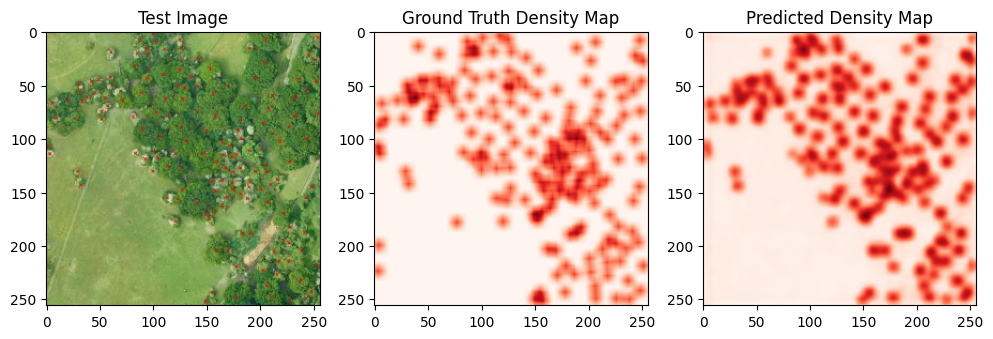

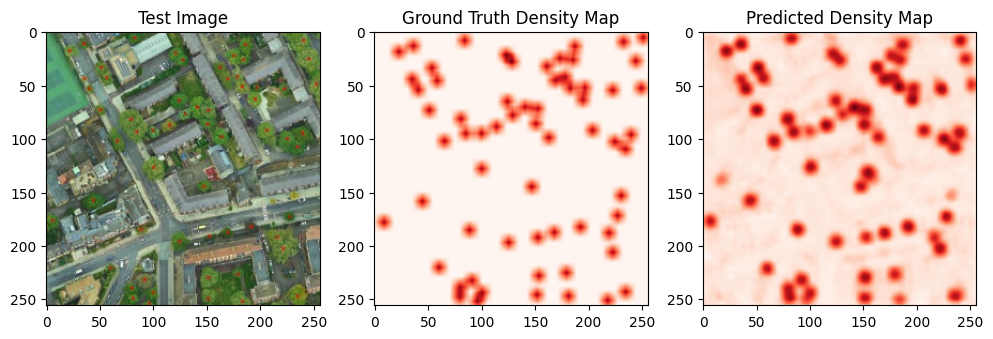

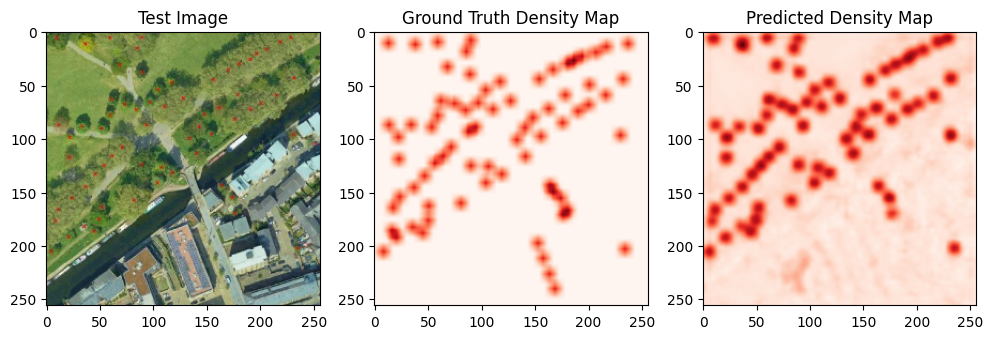

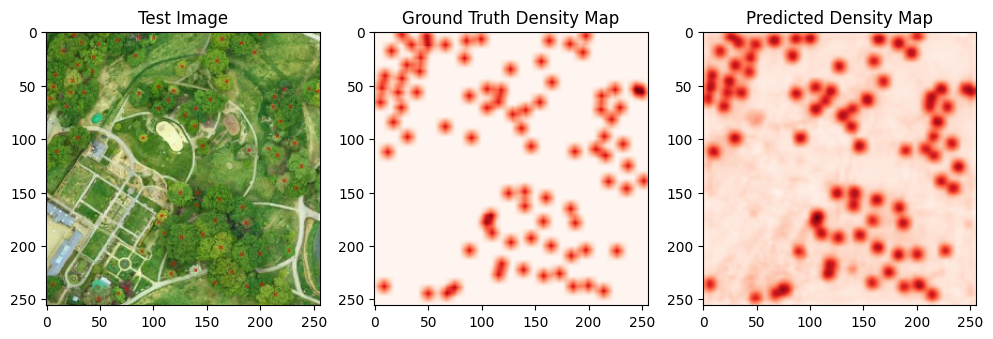

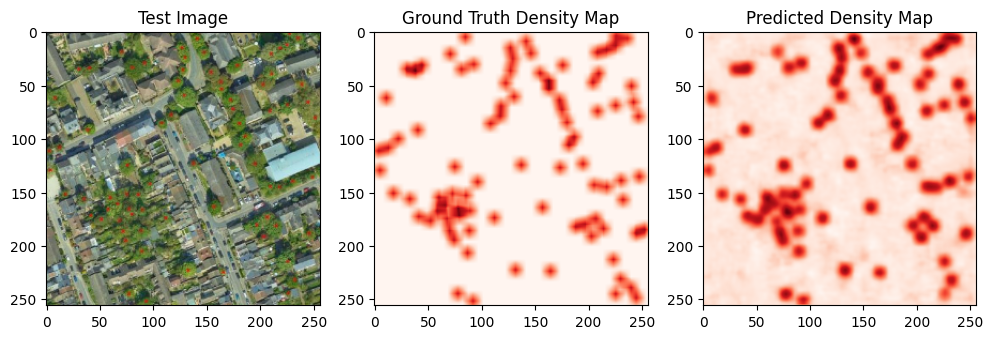

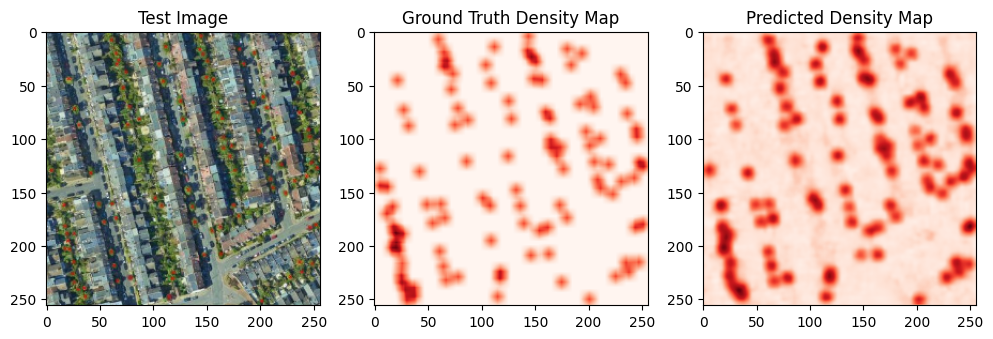

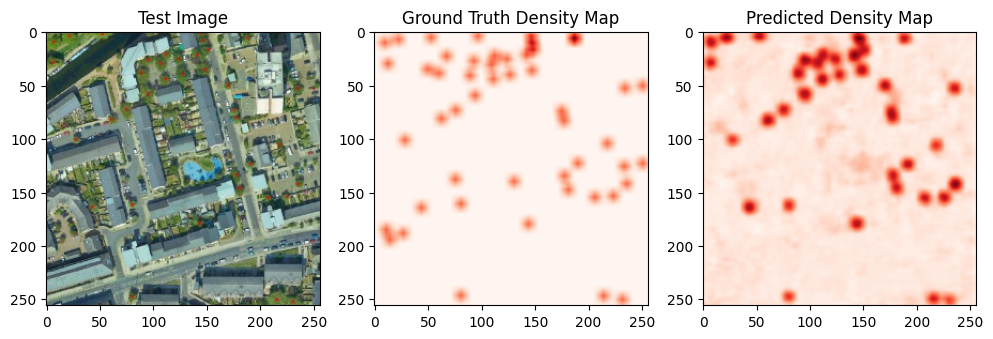

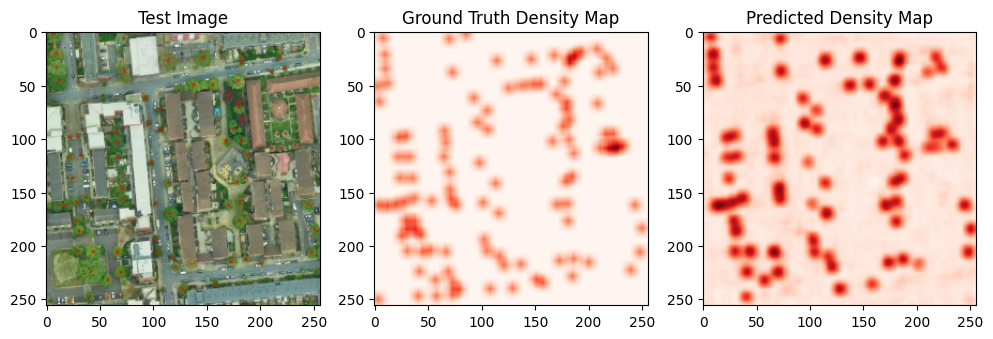

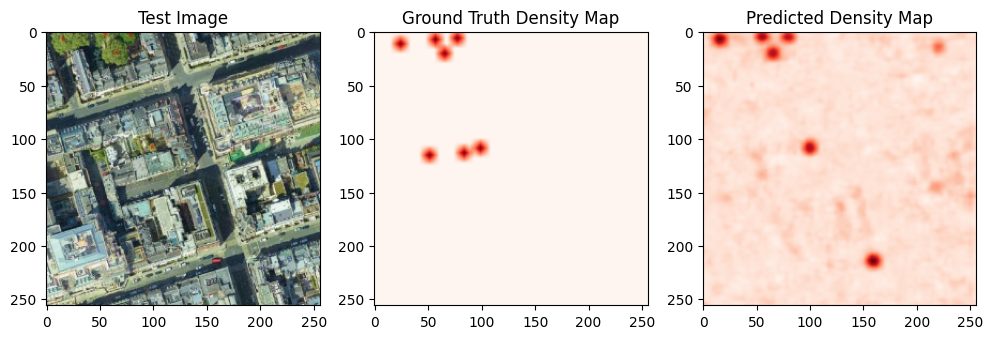

In [ ]:

import matplotlib.pyplot as plt

imgs_pred = simplified_model.predict(test_ds)

# Display test images, predicted density maps, and ground truth density maps
for (img_pred, _), (img, dens_gt) in zip(zip(imgs_pred, test_ds.unbatch().as_numpy_iterator()), test_ds.unbatch().as_numpy_iterator()):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(img)
    axs[0].set_title("Test Image")

    axs[2].imshow(img_pred, cmap="Reds")
    axs[2].set_title("Predicted Density Map")

    axs[1].imshow(dens_gt, cmap="Reds")
    axs[1].set_title("Ground Truth Density Map")

    plt.savefig('/content/drive/MyDrive/hi/test_plot.png')
    plt.show()

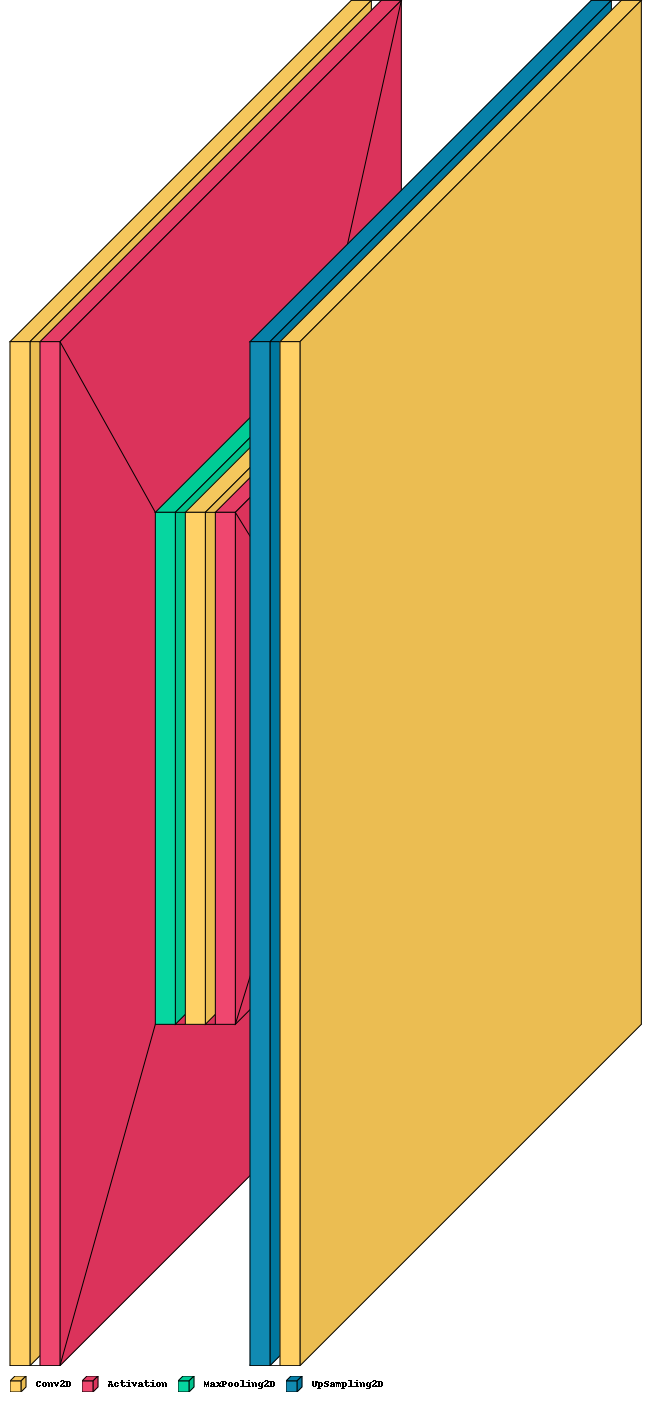

In [ ]:
!pip install visualkeras
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(simplified_model, legend=True)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def calculate_iou(y_true, y_pred):
    intersection = np.sum(np.minimum(y_true, y_pred))
    union = np.sum(np.maximum(y_true, y_pred))
    iou = intersection / union
    return iou

# Assuming imgs_pred and imgs_dens are your predicted and actual values, respectively
imgs_pred_binary = (imgs_pred > 0.1).astype(float)
imgs_dens_binary = (imgs_dens > 0.1).astype(float)

# Flatten the binary arrays if needed
y_true_binary_flat = imgs_dens_binary.ravel()
y_pred_binary_flat = imgs_pred_binary.ravel()

# Calculate and print IoU
iou_result = calculate_iou(y_true_binary_flat, y_pred_binary_flat)
print(f"IoU: {iou_result}")

# Calculate and print accuracy
accuracy_result = accuracy_score(y_true_binary_flat, y_pred_binary_flat)
print(f"Accuracy: {accuracy_result}")

# Calculate and print precision
precision_result = precision_score(y_true_binary_flat, y_pred_binary_flat)
print(f"Precision: {precision_result}")

# Calculate and print recall
recall_result = recall_score(y_true_binary_flat, y_pred_binary_flat)
print(f"Recall: {recall_result}")


IoU: 0.7306870949969829
Accuracy: 0.9129791259765625
Precision: 0.847717837271875
Recall: 0.8410874016271161


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

def calculate_mae(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    return mae

def calculate_r2_score(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    return r2

# Assuming imgs_pred and imgs_dens are your predicted and actual values, respectively
imgs_pred = simplified_model.predict(test_ds)
imgs_dens = np.stack([dens for _, dens in test_ds.unbatch().as_numpy_iterator()])

# Flatten the arrays if needed
y_true_flat = imgs_dens.ravel()
y_pred_flat = imgs_pred.ravel()

# Calculate and print RMSE
rmse_result = calculate_rmse(y_true_flat, y_pred_flat)
print(f"RMSE: {rmse_result}")

# Calculate and print MAE
mae_result = calculate_mae(y_true_flat, y_pred_flat)
print(f"MAE: {mae_result}")

# Calculate and print R2 score
r2_result = calculate_r2_score(y_true_flat, y_pred_flat)
print(f"R2 Score: {r2_result}")

1/1 [==============================] - 0s 41ms/step
RMSE: 0.12034908682107925
MAE: 0.06347297877073288
R2 Score: 0.7442619990387929


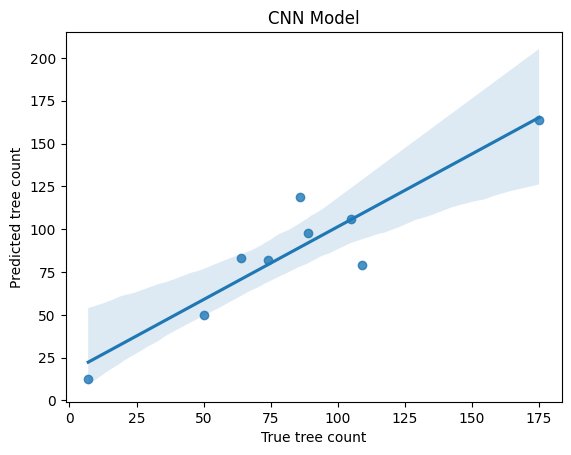

In [ ]:
from sklearn.linear_model import LinearRegression
import seaborn as sns

tree_cnt = []
subpath = 'test'
for img_path in glob(f'/content/drive/MyDrive/hi/{subpath}/images/*.jpg'):
    label_path = img_path.replace('/images/','/labels/').replace('.jpg','.txt')
    labels = np.loadtxt(label_path,delimiter=' ')
    tree_cnt.append(len(labels))
tree_cnt = np.array(tree_cnt)

total_dens_pred = tf.reduce_sum(imgs_pred, axis=[1,2,3]).numpy()
density_constant = LinearRegression().fit(total_dens_pred.reshape(-1,1),tree_cnt).coef_[0]
total_dens_pred = tf.reduce_sum(imgs_pred, axis=[1,2,3]).numpy()

fig,ax = plt.subplots()
sns.regplot(x=tree_cnt,y=total_dens_pred*density_constant,ax=ax)
ax.set_xlabel('True tree count')
ax.set_ylabel('Predicted tree count')
ax.set_title('CNN Model')
plt.show()